In [31]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#set plot styles and figure size
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

#set random state
RANDOM_STATE = 42

In [32]:
#load the NASCAR dataset from a CSV file
CSV_PATH = "NASCAR 2017-2024 Full Race  Points Data - Cup.csv"
df = pd.read_csv(CSV_PATH)

#print the dataset shape and column names
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (11325, 18)
Columns: ['year', 'race_num', 'track', 'track_type', 'fin', 'start', 'car_num', 'driver', 'manu', 'team_name', 'laps', 'laps_led', 'status', 'points', 'stage_1', 'stage_2', 'stage_3_or_duel', 'stage_points']


,year,race_num,track,track_type,fin,start,car_num,driver,manu,team_name,laps,laps_led,status,points,stage_1,stage_2,stage_3_or_duel,stage_points
0,2017,-1,Daytona,superspeedway,1,1,24,Chase Elliott,Chevrolet,Hendrick Motorsports,60,25,running,NaN,NaN,NaN,1.0,10
1,2017,-1,Daytona,superspeedway,2,12,1,Jamie McMurray,Chevrolet,Chip Ganassi Racing,60,0,running,NaN,NaN,NaN,2.0,9
2,2017,-1,Daytona,superspeedway,3,4,4,Kevin Harvick,Ford,Stewart-Haas Racing,60,0,running,NaN,NaN,NaN,3.0,8
3,2017,-1,Daytona,superspeedway,4,2,2,Brad Keselowski,Ford,Team Penske,60,28,running,NaN,NaN,NaN,4.0,7
4,2017,-1,Daytona,superspeedway,5,5,20,Matt Kenseth,Toyota,Joe Gibbs Racing,60,0,running,NaN,NaN,NaN,5.0,6


In [33]:
#Pre-processing the data

#define the expected columns that we want to work with
expected_cols = {
    "year","race_num","track","track_type","fin","start","car_num",
    "driver","manu","team_name","laps","laps_led","status","points",
    "stage_1","stage_2","stage_3_or_duel","stage_points"
}

#check if there is any missing information
missing = expected_cols.difference(df.columns)
if missing:
    print("NOTE: These expected columns were not found:", missing)

#drop rows with missing key columns needed for modeling
key_cols = ["fin", "start", "track_type", "manu", "team_name", "race_num", "year"]
df = df.dropna(subset=[c for c in key_cols if c in df.columns])


In [34]:
#keeping rows to only include the races that greater or equal to 1
if "race_num" in df.columns:
    df = df[df["race_num"] >= 1].copy()

#drop rows that are missing important columns
needed = ["fin", "start", "year", "race_num", "track_type", "manu", "team_name"]
df = df.dropna(subset=[c for c in needed if c in df.columns]).copy()

#create the target variable, if the driver finished in the top 10, then it's 1, if the driver did not finish in the top 10, then it is 0
df["top_10_finish"] = (df["fin"] <= 10).astype(int)


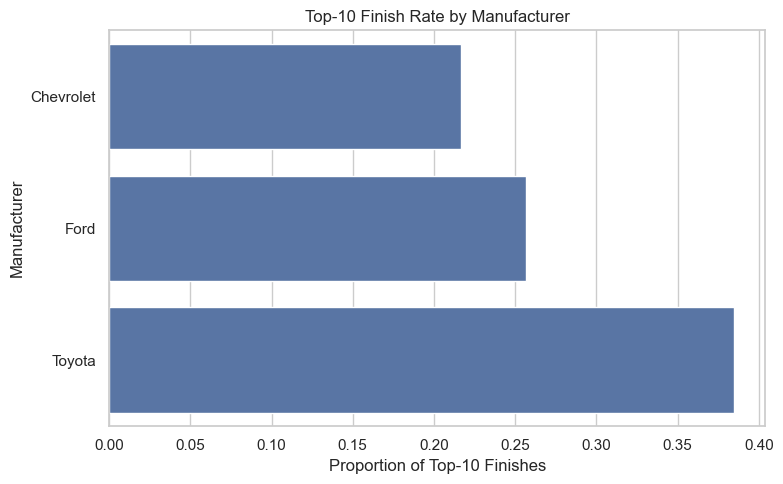

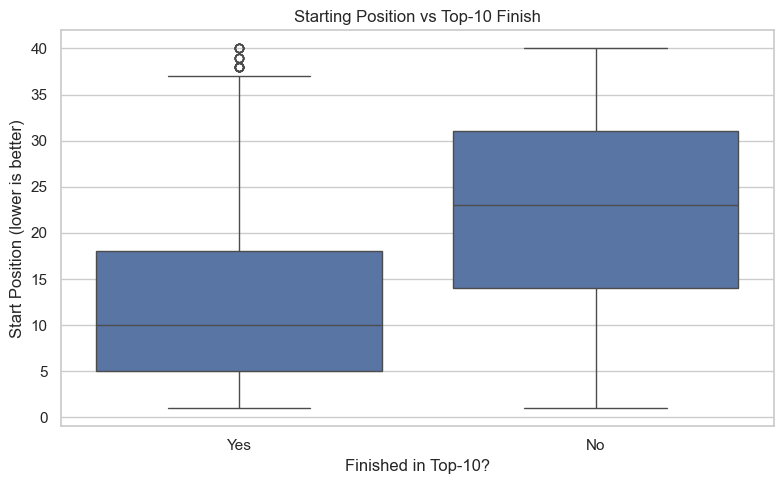

In [35]:
#Data Understanding / Visualization

#Top‑10 rate by manufacturer (bar chart)
if "manu" in df.columns:
    manu_rate = (df.groupby("manu")["top_10_finish"].mean().sort_values())
    sns.barplot(x=manu_rate.values, y=manu_rate.index)
    plt.xlabel("Proportion of Top-10 Finishes")
    plt.ylabel("Manufacturer")
    plt.title("Top-10 Finish Rate by Manufacturer")
    plt.tight_layout()
    plt.show()

#Starting position vs Top‑10 (boxplot)
sns.boxplot(x=df["top_10_finish"].map({0:"No",1:"Yes"}), y=df["start"])
plt.xlabel("Finished in Top-10?")
plt.ylabel("Start Position (lower is better)")
plt.title("Starting Position vs Top-10 Finish")
plt.tight_layout()
plt.show()


In [36]:
#define categorical and numerical columns
cat_cols = ["track_type", "manu", "team_name"]
num_cols = ["start", "year", "race_num"]

#convert categorical variables into one-hot encoded columns
X = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

#set the target variable
y = df["top_10_finish"].values

#scale the numeric features to make sure it's equal
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#print the shape input / output
print("X shape:", X.shape, " | y shape:", y.shape)


X shape: (10988, 50)  | y shape: (10988,)


In [37]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)


=== Naive Bayes — Test Results ===
Accuracy: 0.435
Confusion Matrix:
 [[ 483 1544]
 [   9  711]]
Classification Report:
               precision    recall  f1-score   support

           0      0.982     0.238     0.383      2027
           1      0.315     0.988     0.478       720

    accuracy                          0.435      2747
   macro avg      0.649     0.613     0.431      2747
weighted avg      0.807     0.435     0.408      2747


Cross-Validation (Naive Bayes) - mean: 0.448  std: 0.046  scores: [0.461 0.498 0.475 0.364 0.442]


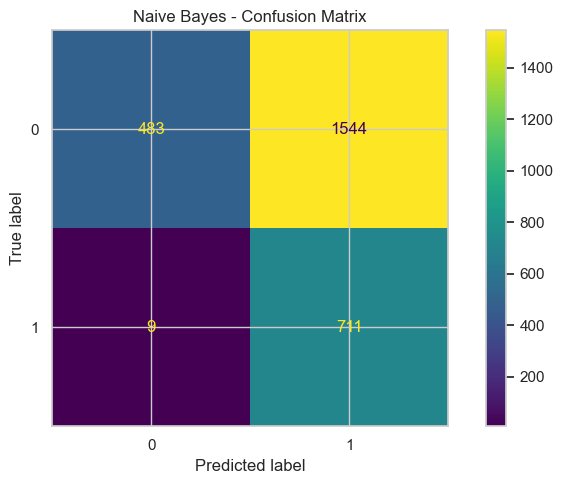

In [38]:
#Naive Bayes

#train Native Bayes Model
nb = GaussianNB()
nb.fit(X_train, y_train)

#predict on test set
y_pred_nb = nb.predict(X_test)
y_proba_nb = nb.predict_proba(X_test)[:, 1]

#evaluate the results
print("=== Naive Bayes — Test Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_nb), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb, digits=3))

#cross‑validation
cv_nb = cross_val_score(nb, X, y, cv=5, scoring="accuracy")
print("\nCross-Validation (Naive Bayes) - mean:", round(cv_nb.mean(), 3), 
      " std:", round(cv_nb.std(), 3), " scores:", np.round(cv_nb, 3))

#plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)
plt.title("Naive Bayes - Confusion Matrix")
plt.tight_layout(); plt.show()

=== Random Forest — Test Results ===
Accuracy: 0.749
Confusion Matrix:
 [[1747  280]
 [ 409  311]]
Classification Report:
               precision    recall  f1-score   support

           0      0.810     0.862     0.835      2027
           1      0.526     0.432     0.474       720

    accuracy                          0.749      2747
   macro avg      0.668     0.647     0.655      2747
weighted avg      0.736     0.749     0.741      2747


Cross-Validation (Random Forest) — mean: 0.736  std: 0.017  scores: [0.763 0.745 0.737 0.717 0.72 ]


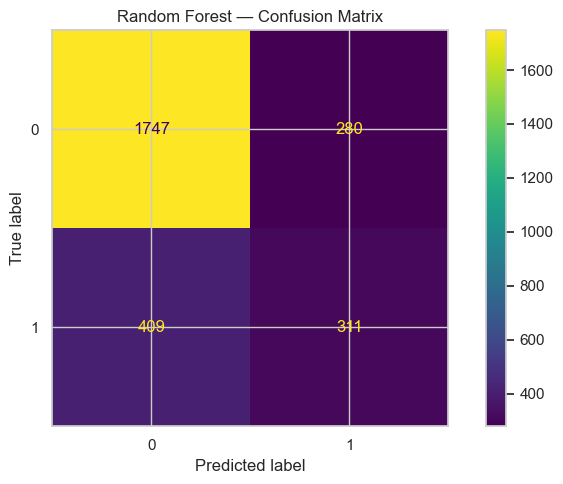

In [39]:
#Random Forest

#train Random Forest Model
rf = RandomForestClassifier(
    n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)

#predict on test set
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

#evaluate the results
print("=== Random Forest — Test Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=3))

#cross-validation
cv_rf = cross_val_score(rf, X, y, cv=5, scoring="accuracy", n_jobs=-1)
print("\nCross-Validation (Random Forest) — mean:", round(cv_rf.mean(), 3), 
      " std:", round(cv_rf.std(), 3), " scores:", np.round(cv_rf, 3))

#plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Random Forest — Confusion Matrix")
plt.tight_layout(); plt.show()

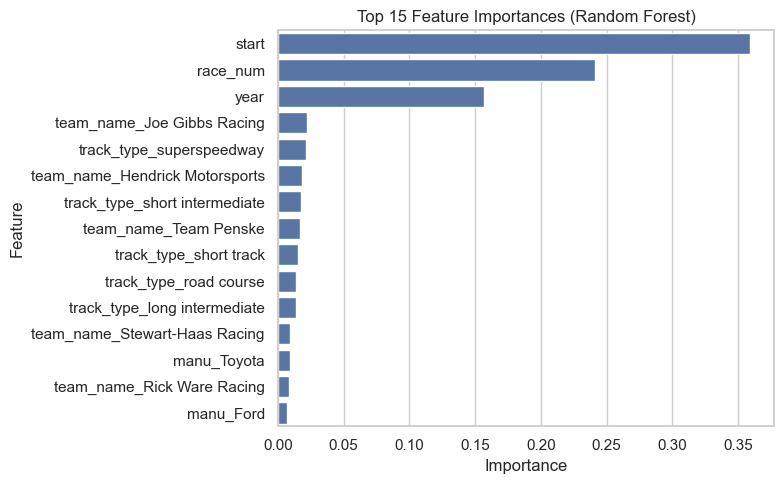

In [40]:
#Which features matter? (Random Forest)
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top15 = imp.head(15)
sns.barplot(x=top15.values, y=top15.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
